<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#covar-calculations" data-toc-modified-id="covar-calculations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>covar calculations</a></span></li></ul></div>

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas_datareader.data as web
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg as qr
import statsmodels.api as sma
import pickle
import warnings
warnings.filterwarnings('ignore')

In [215]:
system = yf.download('^GSPC', 
                      progress=False)
system.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


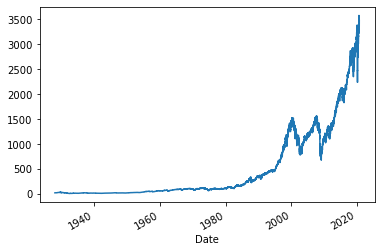

In [216]:
system['Adj Close'].plot()

In [49]:
snp_stocks = pd.read_csv('./Data/SPstocks_current.csv' )
snp_stocks = list(snp_stocks[snp_stocks.columns[0]])

In [158]:
def download_stock(stock):
    """ try to query the iex for a stock, if failed note with print """
    try:
        #print(stock)
        stock_df = web.DataReader(stock,'yahoo',start=dt.date(1970,1,1))
        stock_df['Name'] = stock
        output_name = stock + '_data.csv'
        #stock_df.to_csv(output_name)
        return stock_df
    except:
        bad_names.append(stock)
        print('bad: %s' % (stock))

In [159]:
bad_names = []
stock_data = {}
for sym in snp_stocks:
    try:
        stock_data[sym] = download_stock(sym)
    except:
        pass

bad: AGN
bad: APC
bad: BCR
bad: BBT
bad: BRK.B
bad: BF.B
bad: CBG
bad: CBS
bad: CELG
bad: CTL
bad: CHK
bad: COH
bad: DPS
bad: ETFC
bad: FTR
bad: GGP
bad: HRS
bad: HCP
bad: LLL
bad: LUK
bad: LVLT
bad: LLTC
bad: MJN
bad: KORS
bad: PCLN
bad: RHT
bad: RAI
bad: SPLS
bad: SYMC
bad: TSO
bad: TMK
bad: TSS
bad: UTX
bad: VIAB
bad: HCN
bad: WFM
bad: WYN
bad: YHOO


In [210]:
with open('./Data/stock_data','wb') as f:
    pickle.dump(stock_data,f,pickle.HIGHEST_PROTOCOL)

In [164]:
for sym in bad_names:
    stock_data.pop(sym)

In [211]:
with open('./Data/stock_data','rb') as f:
    stock_data = pickle.load(f)

In [218]:
sector = pd.read_csv('./Data/snp_tickers_sectors.csv',index_col = 0)
sector

,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",8/9/1976,66740.0,1902
ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/1964,1800.0,1888
ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/2012,1551152.0,2013 (1888)
ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",5/31/2018,815094.0,1981
ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/2011,1467373.0,1989
...,...,...,...,...,...,...,...,...
YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",10/6/1997,1041061.0,1997
ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",12/23/2019,877212.0,1969
ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",8/7/2001,1136869.0,1927


# covar calculations

In [147]:
def quantile_reg(system_losses,roll_var,q):
    Y = system_losses.copy()
    X = roll_var.copy()
    common_index = X.dropna().index.intersection(Y.dropna().index)
    X = X.loc[common_index]
    Y = Y.loc[common_index]
    model = qr(Y,sma.add_constant(X)).fit(q = 0.99)
    return model
    
    
    
    

def est_delta_covar(system_losses,stock_losses,q,roll_window,method='emp'):
    if((method != 'emp')and(method!='norm')):
        raise Exception('Wrong input for method')
    
    if(method == 'emp'):
        roll_var = stock_losses.rolling(window = roll_window,min_periods = int(0.8*roll_window))\
                                    .apply(lambda x: np.quantile(x,q))
        
        roll_median = stock_losses.rolling(window = roll_window,min_periods = int(0.8*roll_window)).median()
        
    else:
        roll_median = stock_losses.rolling(window = roll_window,min_periods = int(0.8*roll_window)).mean()
        std = stock_losses.rolling(window = roll_window,min_periods = int(0.8*roll_window)).std()
        
        roll_var = roll_median + stats.norm.ppf(q) * std
        
    model_q = quantile_reg(system_losses,roll_var,q)
    model_median = quantile_reg(system_losses,roll_median,q)
        
        #import pdb;pdb.set_trace()
        
    delta_covar = model_q.params['Adj Close'] * (model_q.fittedvalues - model_median.fittedvalues)

        
    return delta_covar,roll_var

        


In [165]:
stock_losses = {}
for sym in stock_data.keys():
        adj_close = stock_data[sym]['Adj Close'].resample('1W').last().dropna()
        stock_losses[sym] = 100* (adj_close.shift(1) - adj_close)/adj_close.shift(1)

In [166]:
system_close = system['Adj Close'].resample('1W').last().dropna()
system_losses = 100* (system_close.shift(1) - system_close)/system_close.shift(1)

In [219]:
delta_covar_dict = {}
roll_var_dict = {}
shock_df = pd.DataFrame()
normal_df = pd.DataFrame()
roll_window = 52*3
normal_date = dt.date(2015,12,13)
q = 0.99

for sym in stock_data.keys():
    
    try:
        delta_covar_dict[sym],roll_var_dict[sym] = est_delta_covar(system_losses,stock_losses[sym],q,roll_window)
        shock_df.loc[sym,'Delta Covar'] = delta_covar_dict[sym][-1]
        shock_df.loc[sym,'VaR'] = roll_var_dict[sym][-1]
        shock_df.loc[sym,'Sector'] = sector.loc[sym,'GICS Sector']

        normal_df.loc[sym,'Delta Covar'] = delta_covar_dict[sym].loc[normal_date]
        normal_df.loc[sym,'VaR'] = roll_var_dict[sym].loc[normal_date]
        normal_df.loc[sym,'Sector'] = sector.loc[sym,'GICS Sector']
    except:
        print(sym)

ABT
ABBV
ACN
ATVI
AYI
ADBE
AAP
AES
AET
AMG
AFL
A
APD
AKAM
ALK
ALB
ALXN
ALLE
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANTM
AON
APA
AIV
AAPL
AMAT
ADM
ARNC
AJG
AIZ
T
ADSK
ADP
AN
AZO
AVB
AVY
BHI
BLL
BAC
BAX
BDX
BBBY
BBY
BIIB
BLK
HRB
BA
BWA
BXP
BSX
BMY
AVGO
CHRW
CA
COG
CPB
COF
CAH
KMX
CCL
CAT
CBOE
CNC
CNP
CERN
CF
SCHW
CHTR
CVX
CMG
CB
CHD
CI
XEC
CINF
CTAS
CSCO
C
CFG
CTXS
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
CXO
COP
ED
STZ
GLW
COST
COTY
CCI
CSRA
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DLPH
DAL
XRAY
DVN
DLR
DFS
DISCA
DISCK
DG
DLTR
D
DOV
DOW
DTE
DD
DUK
DNB
EMN
ETN
EBAY
ECL
EIX
EW
EA
EMR
ETR
EVHC
EOG
EQT
EFX
EQIX
EQR
ESS
EL
ES
EXC
EXPE
EXPD
ESRX
EXR
XOM
FFIV
FB
FAST
FRT
FDX
FIS
FITB
FSLR
FE
FISV
FLIR
FLS
FLR
FMC
FTI
FL
F
FTV
FBHS
BEN
FCX
GPS
GRMN
GD
GE
GIS
GM
GPC
GILD
GPN
GS
GT
GWW
HAL
HBI
HOG
HAR
HIG
HAS
HCA
HP
HSIC
HES
HPE
HOLX
HD
HON
HRL
HST
HPQ
HUM
HBAN
IDXX
ITW
ILMN
INCY
IR
INTC
ICE
IBM
IP
IPG
IFF
INTU
ISRG
IVZ
IRM
JBHT
JEC
SJM
JNJ
JCI
JPM
JNPR
KSU
K
KEY
KMB
KI

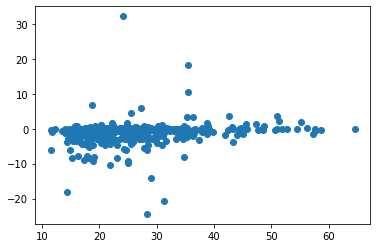

In [185]:
plt.scatter(normal_df['VaR']*(13**0.5),normal_df['Delta Covar']*(13**0.5))

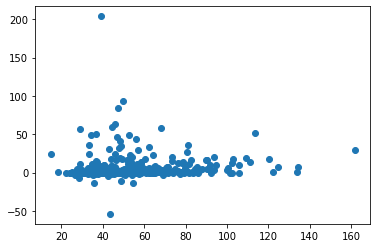

In [186]:
plt.scatter(shock_df['VaR']*(13**0.5),shock_df['Delta Covar']*(13**0.5))

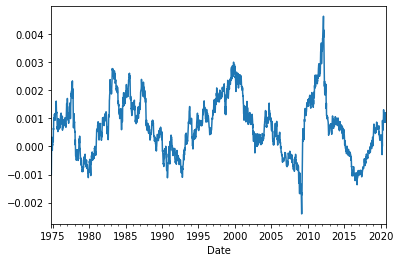

In [150]:
delta_covar.plot()

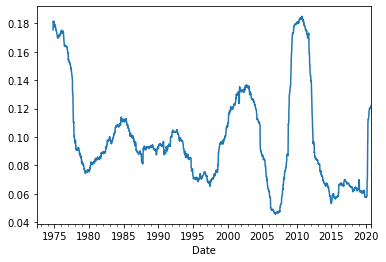

In [151]:
roll_var.plot()

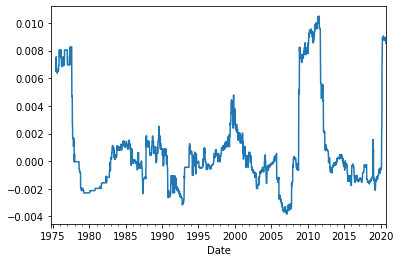

In [154]:
delta_covar.plot()

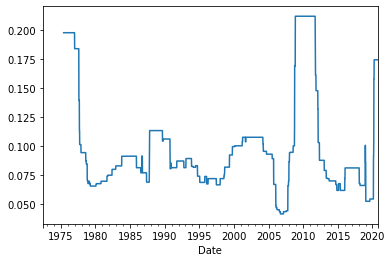

In [155]:
roll_var.plot()

In [65]:
k = stats.norm.ppf(0.99)
roll_window = 3*52
min_periods = 2*52
sym = 'AXP'




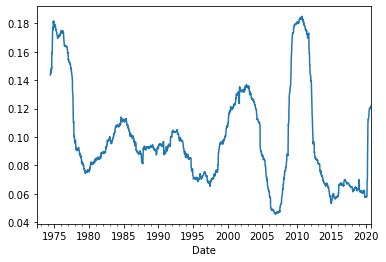

In [66]:
adj_close = stock_data[sym]['Adj Close']
adj_close = adj_close.resample('1W').last().dropna()
stock_losses = (adj_close.shift(1) - adj_close)/adj_close.shift(1)
mean = stock_losses.rolling(window = roll_window,min_periods = min_periods).mean()
std = stock_losses.rolling(window = roll_window,min_periods = min_periods).std()
roll_var = mean + k * std
roll_var.plot()

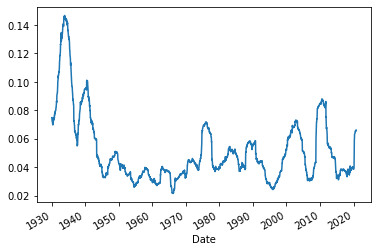

In [68]:
system_close = system['Adj Close'].resample('1W').last().dropna()
system_losses = 100* (system_close.shift(1) - system_close)/system_close.shift(1)
mean = system_losses.rolling(window = roll_window,min_periods = min_periods).mean()
std = system_losses.rolling(window = roll_window,min_periods = min_periods).std()
system_roll_var = mean + k*std
system_roll_var.plot()

In [103]:
Y = system_losses.copy()
X = roll_var2.copy()
common_index = X.dropna().index.intersection(Y.dropna().index)
X = X.loc[common_index]
Y = Y.loc[common_index]

model = qr(Y,sma.add_constant(X)).fit(q = 0.99)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:              Adj Close   Pseudo R-squared:              0.03612
Model:                       QuantReg   Bandwidth:                    0.008993
Method:                 Least Squares   Sparsity:                        2.008
Date:                Sat, 10 Oct 2020   No. Observations:                 2368
Time:                        13:41:59   Df Residuals:                     2366
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.007      4.925      0.000       0.022       0.051
Adj Close      0.2795      0.062      4.513      0.000       0.158       0.401
==============================================================================
"""

In [106]:
model.fittedvalues[-100] - median[-100]

0.05807383827446461

In [107]:
roll_var2[-100]

0.06618460537010828

In [102]:
roll_var2 = stock_losses.rolling(window = roll_window,min_periods= min_periods).apply(lambda x: np.quantile(x,0.99))
median = stock_losses.rolling(window = roll_window,min_periods= min_periods).apply(lambda x: np.quantile(x,0.5))

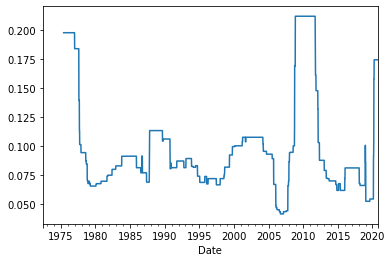

In [108]:
roll_var2.plot()